# Projeto de Aprendizado de Máquina

Menbros:

Jardel Almeida Xavier

Luisa Martins Lemos de Souza

Pablo Ernani Nogueira de Oliveira

Tyago Yuji Teoi

## Objetivo

Visão Geral do Projeto

O objetivo deste projeto é criar diferentes tipos de modelos capazes de categorizar as expressões faciais em sete classes distintas:</br> Irritado, Nojo, Medo, Feliz, Triste, Surpreso e Neutro.

## Descrição da Base

O conjunto de dados FER-2013 consiste em imagens de faces em tons de cinza, cada uma medindo 48 x 48 pixels.</br>
Essas imagens passaram por pré-processamento para garantir alinhamento consistente e ocupação espacial semelhante em todas as amostras.</br>
O conjunto de dados compreende um total de 35.887 imagens , com 28.709 imagens alocadas para o conjunto de treinamento e 7.178 imagens designadas para o conjunto de teste.

#### Library install

## Pré-processamento

In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import random
import glob

from keras.utils import load_img
from google.colab import files

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

from sklearn import tree, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install kaggle

#### kaggle API setter

In [ ]:
from google.colab import files

!gdown https://drive.google.com/uc?id=1fpQp9GZ5HFZ2N_rA08I9TDHCbnJsjswS

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1fpQp9GZ5HFZ2N_rA08I9TDHCbnJsjswS
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 437kB/s]


#### unzip kaggle compacted file

In [ ]:
#!kaggle datasets download "msambare/fer2013"
!kaggle datasets download "msambare/fer2013"
!unzip -q fer2013.zip

 96% 58.0M/60.3M [00:03<00:00, 23.2MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.3MB/s]


### Alguns Exemplos



In [ ]:
train_dir = "/content/train/"
test_dir = "/content/test/"

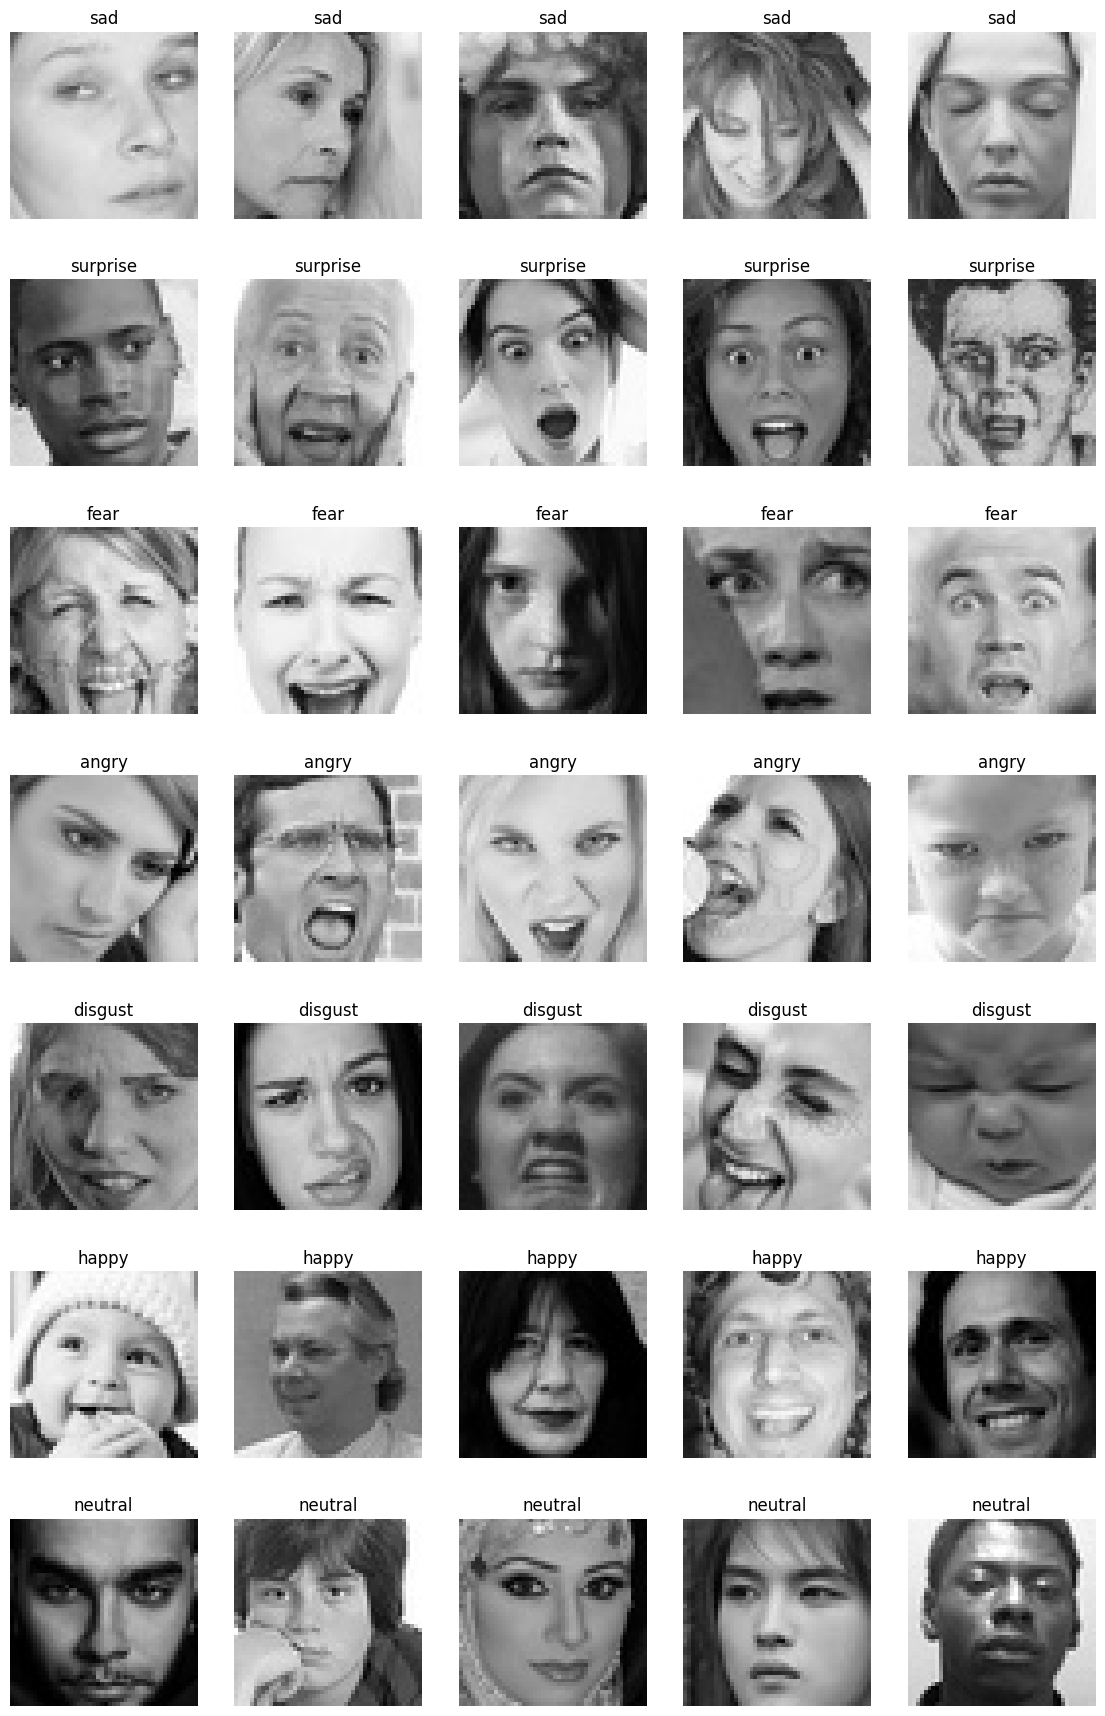

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    for j in range(5):
        img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[random.randint(0,111)]))
        plt.subplot(7, 5, i)
        plt.imshow(img)
        plt.title(expression)
        plt.axis('off')
        i += 1
plt.show()

### Visão Geral

        sad  surprise  fear  angry  disgust  happy  neutral
train  4830      3171  4097   3995      436   7215     4965
       sad  surprise  fear  angry  disgust  happy  neutral
test  1247       831  1024    958      111   1774     1233


<Axes: >

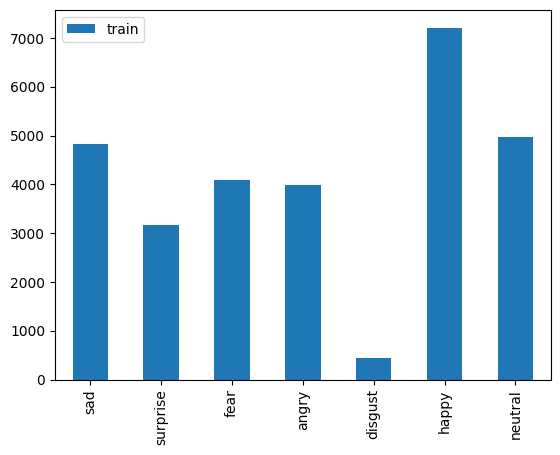

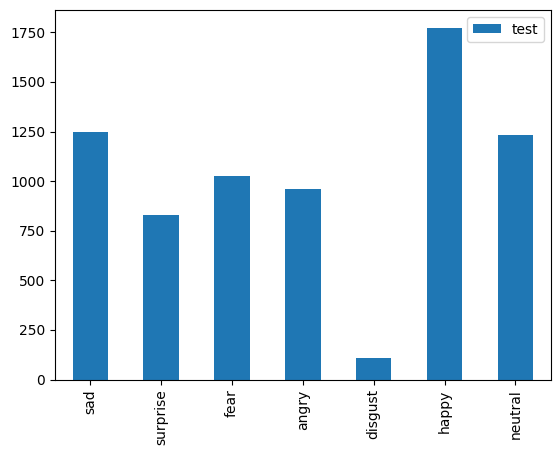

In [ ]:
def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df


train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)
train_count.transpose().plot(kind='bar')
test_count.transpose().plot(kind='bar')

Conseguimos observar que a base de dados tanto na base de treino quanto a de teste estão com a classe *disgust* bem abaixo das outras, já as outras se encontram próximas com exessão da *happy*, que está acima

## Processamento (CLIP)
Um embedding é a tradução de um vetor de alta dimensão em um espaço de baixa dimensão. Idealmente, um embedding captura algumas das semânticas da entrada, juntando entradas semanticamente semelhantes no espaço de embedding.

O modelo CLIP de imagem e texto , que mapeia texto e imagens para um espaço vetorial compartilhado.

O CLIP aprende um espaço de incorporação multimodal treinando em conjunto um codificador de imagem e um codificador de texto para maximizar a semelhança de cosseno das incorporações de imagem e texto do pares reais no lote, minimizando a semelhança de cosseno das incorporações do emparelhamentos incorretos. Uma perda de entropia cruzada simétrica é otimizada sobre essas pontuações de similaridade.

In [ ]:
image_feature_extractor = SentenceTransformer('clip-ViT-B-32')

In [ ]:
L_train = glob.glob("train/*/*.jpg")
L_test = glob.glob("test/*/*.jpg")
# Para não pegar viés pela ordem da lista
random.shuffle(L_train)

# O certo é esse
L_tes = L_train
L_tes2 = L_test
# Esse é apenas para testar com poucos dados
#L_tes = L_train[0:8000]
#L_tes2 = L_test[0:2000]

In [ ]:
imgs_train = []
for imagem in L_tes:
  imgs_train.append(Image.open(imagem))

imgs_test = []
for imagem in L_tes2:
  imgs_test.append(Image.open(imagem))

In [ ]:
embeddings = image_feature_extractor.encode(imgs_train)
embeddings2 = image_feature_extractor.encode(imgs_test)

In [ ]:
embeddings.shape, embeddings2.shape

((28709, 512), (7178, 512))

In [ ]:
#Criando X_Train e y_train
df_data = pd.DataFrame()
df_data['imgs'] = L_tes
df_data['embeddings'] = list(embeddings)
labels = []
for img in df_data['imgs']:
  labels.append(img.split("/")[1])
df_data['labels'] = labels
df_data
X_train = np.array(df_data.embeddings.to_list())
emotion_dict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Transforms string label array to int label array
y_train = np.array(df_data.labels)
for i in range(len(y_train)):
  if y_train[i] in emotion_dict.keys():
    y_train[i] = emotion_dict[y_train[i]]
  else:
    y_train[i] = -1
y_train = y_train.astype('int')



#Criando X_teste e y_test
df_data = pd.DataFrame()
df_data['imgs'] = L_tes2
df_data['embeddings'] = list(embeddings2)
labels = []
for img in df_data['imgs']:
  labels.append(img.split("/")[1])
df_data['labels'] = labels
df_data
X_test = np.array(df_data.embeddings.to_list())
emotion_dict = {
    'angry': 0,
    'disgust': 1,
    'fear': 2,
    'happy': 3,
    'neutral': 4,
    'sad': 5,
    'surprise': 6
}

# Transforms string label array to int label array
y_test = np.array(df_data.labels)
for i in range(len(y_test)):
  if y_test[i] in emotion_dict.keys():
    y_test[i] = emotion_dict[y_test[i]]
  else:
    y_test[i] = -1
y_test = y_test.astype('int')

##Modelos

### Paradigma Simbólico - Árvores de Decisão




In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=2023)
clf.fit(X_train ,y_train)
y_pred_Tree = clf.predict(X_test)

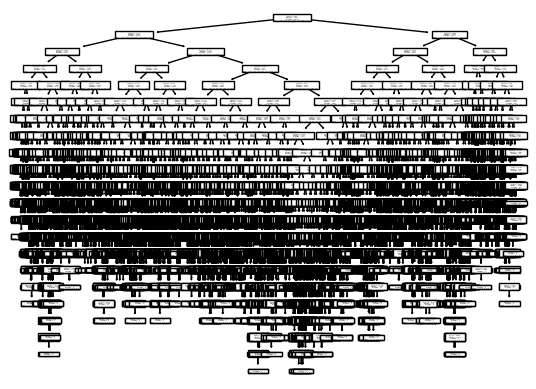

In [ ]:
tree.plot_tree(clf)
plt.show()

####Matriz de Confusão

              precision    recall  f1-score   support

       angry       0.35      0.35      0.35       958
     disgust       0.39      0.38      0.39       111
        fear       0.32      0.34      0.33      1024
       happy       0.67      0.65      0.66      1774
     neutral       0.41      0.41      0.41      1233
         sad       0.37      0.37      0.37      1247
    surprise       0.58      0.59      0.58       831

    accuracy                           0.46      7178
   macro avg       0.44      0.44      0.44      7178
weighted avg       0.47      0.46      0.47      7178



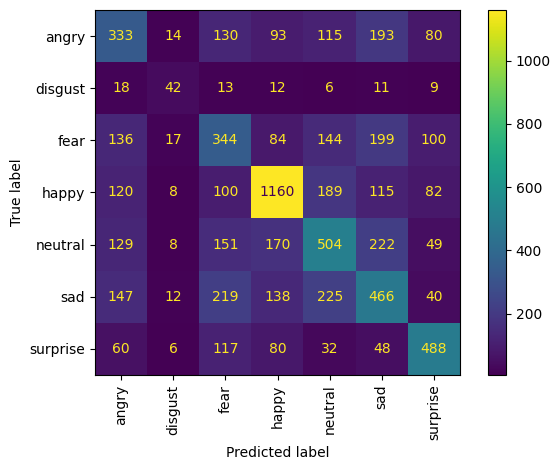

In [ ]:
target_names=emotion_dict
print(classification_report(y_test, y_pred_Tree, target_names=emotion_dict))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

###Paradigma Estatístico

In [ ]:
clf = svm.SVC(kernel='rbf',gamma=0.000001,C=100000, random_state=2023)
clf.fit(X_train ,y_train)
y_pred_SVM = clf.predict(X_test)

####Matriz de Confusão

              precision    recall  f1-score   support

       angry       0.59      0.60      0.60       958
     disgust       0.61      0.34      0.44       111
        fear       0.49      0.38      0.43      1024
       happy       0.86      0.90      0.88      1774
     neutral       0.63      0.69      0.66      1233
         sad       0.56      0.58      0.57      1247
    surprise       0.75      0.77      0.76       831

    accuracy                           0.67      7178
   macro avg       0.64      0.61      0.62      7178
weighted avg       0.66      0.67      0.66      7178



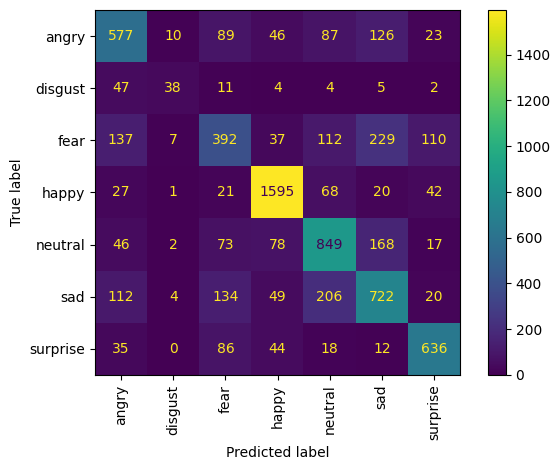

In [ ]:
target_names=emotion_dict
print(classification_report(y_test, y_pred_SVM, target_names=emotion_dict))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

###Paradigma Probabílistico

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X_train)
X_trainn = pd.DataFrame(d)

scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X_test)
X_testt = pd.DataFrame(d)

In [ ]:
clf = MultinomialNB()
clf.fit(X_trainn ,y_train.T)
y_pred_NB = clf.predict(X_testt)


####Matriz de Confusão

              precision    recall  f1-score   support

       angry       0.44      0.37      0.40       958
     disgust       0.50      0.01      0.02       111
        fear       0.35      0.12      0.18      1024
       happy       0.59      0.87      0.70      1774
     neutral       0.51      0.55      0.53      1233
         sad       0.47      0.46      0.47      1247
    surprise       0.58      0.64      0.61       831

    accuracy                           0.53      7178
   macro avg       0.49      0.43      0.42      7178
weighted avg       0.50      0.53      0.50      7178



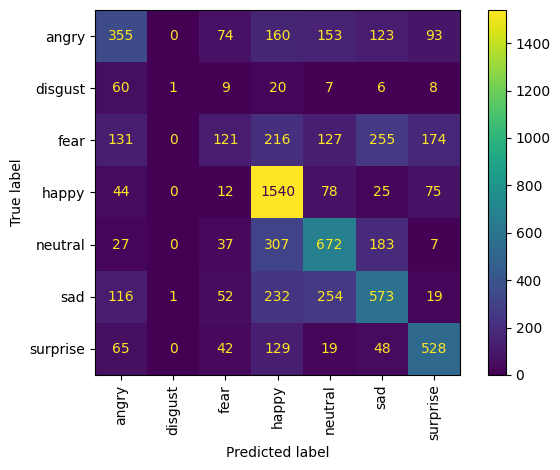

In [ ]:
target_names=emotion_dict
print(classification_report(y_test, y_pred_NB, target_names=emotion_dict))
ConfusionMatrixDisplay.from_estimator(
    clf, X_testt, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

### Paradigma Conexionista -

#### Definindo semente para reprodutibilidade

In [ ]:
np.random.seed(2023)
tf.random.set_seed(2023)

#### Definindo batch size

In [ ]:
batch_size = 64

#### Criação do data generator para o conjunto de treino com data augmentation

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

#### Criação do data generator para o conjunto de teste

In [ ]:
test_data_generator = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True
)

#### Carregamento e preprocessamento do conjunto de treino

In [ ]:
training_set = train_data_generator.flow_from_directory(
    '/content/train',
    color_mode='grayscale',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
)

Found 22968 images belonging to 7 classes.


#### Carregamento e preprocessamento dos conjunto de validação

In [ ]:
validation_set = train_data_generator.flow_from_directory(
    '/content/train',
    color_mode='grayscale',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 5741 images belonging to 7 classes.


#### Carregamento e preprocessamento dos conjunto de teste

In [ ]:
test_set = test_data_generator.flow_from_directory(
    '/content/test',
    color_mode='grayscale',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 7178 images belonging to 7 classes.


#### Definindo o modelo de CNN

In [ ]:
weight_decay = 0.0001

model = Sequential()
model.add(Conv2D(64, (4, 4), activation='relu', padding='same', input_shape=(48, 48, 1), kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(Conv2D(64, (4, 4), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (4, 4), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (4, 4), activation='relu', padding='same', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))

#### Compilando o modelo

In [ ]:
model.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1088      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                      

#### Definindo callbacks

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/tmp/checkpoint', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

#### Definindo quantidade de etapas de validação por época para os conjuntos treino, teste e validação

In [ ]:
train_steps_per_epoch = training_set.n // training_set.batch_size
test_steps_per_epoch = test_set.n // test_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

print(train_steps_per_epoch)
print(test_steps_per_epoch)
print(validation_steps)

358
112
89


#### Treinamento do modelo

In [ ]:
history = model.fit(
training_set,
steps_per_epoch=train_steps_per_epoch,
epochs=100,
validation_data=validation_set,
validation_steps=validation_steps,
callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
358/358 [==============================] - ETA: 0s - loss: 1.5295 - accuracy: 0.4165
Epoch 1: val_accuracy improved from 0.18522 to 0.43416, saving model to /tmp/checkpoint


358/358 [==============================] - 34s 94ms/step - loss: 1.5295 - accuracy: 0.4165 - val_loss: 1.4743 - val_accuracy: 0.4342
Epoch 2/100
358/358 [==============================] - ETA: 0s - loss: 1.4441 - accuracy: 0.4517
Epoch 2: val_accuracy improved from 0.43416 to 0.43434, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 93ms/step - loss: 1.4441 - accuracy: 0.4517 - val_loss: 1.5106 - val_accuracy: 0.4343
Epoch 3/100
358/358 [==============================] - ETA: 0s - loss: 1.3890 - accuracy: 0.4766
Epoch 3: val_accuracy improved from 0.43434 to 0.48367, saving model to /tmp/checkpoint


358/358 [==============================] - 36s 101ms/step - loss: 1.3890 - accuracy: 0.4766 - val_loss: 1.3663 - val_accuracy: 0.4837
Epoch 4/100
358/358 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.4957
Epoch 4: val_accuracy improved from 0.48367 to 0.50439, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 93ms/step - loss: 1.3465 - accuracy: 0.4957 - val_loss: 1.3217 - val_accuracy: 0.5044
Epoch 5/100
358/358 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.5113
Epoch 5: val_accuracy improved from 0.50439 to 0.51773, saving model to /tmp/checkpoint


358/358 [==============================] - 31s 88ms/step - loss: 1.3097 - accuracy: 0.5113 - val_loss: 1.2868 - val_accuracy: 0.5177
Epoch 6/100
358/358 [==============================] - ETA: 0s - loss: 1.2769 - accuracy: 0.5252
Epoch 6: val_accuracy improved from 0.51773 to 0.53634, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 93ms/step - loss: 1.2769 - accuracy: 0.5252 - val_loss: 1.2453 - val_accuracy: 0.5363
Epoch 7/100
358/358 [==============================] - ETA: 0s - loss: 1.2465 - accuracy: 0.5370
Epoch 7: val_accuracy did not improve from 0.53634
358/358 [==============================] - 29s 82ms/step - loss: 1.2465 - accuracy: 0.5370 - val_loss: 1.2653 - val_accuracy: 0.5195
Epoch 8/100
358/358 [==============================] - ETA: 0s - loss: 1.2277 - accuracy: 0.5478
Epoch 8: val_accuracy improved from 0.53634 to 0.55056, saving model to /tmp/checkpoint


358/358 [==============================] - 32s 90ms/step - loss: 1.2277 - accuracy: 0.5478 - val_loss: 1.2169 - val_accuracy: 0.5506
Epoch 9/100
358/358 [==============================] - ETA: 0s - loss: 1.2056 - accuracy: 0.5538
Epoch 9: val_accuracy did not improve from 0.55056
358/358 [==============================] - 30s 84ms/step - loss: 1.2056 - accuracy: 0.5538 - val_loss: 1.2399 - val_accuracy: 0.5397
Epoch 10/100
358/358 [==============================] - ETA: 0s - loss: 1.1887 - accuracy: 0.5613
Epoch 10: val_accuracy improved from 0.55056 to 0.55284, saving model to /tmp/checkpoint


358/358 [==============================] - 32s 89ms/step - loss: 1.1887 - accuracy: 0.5613 - val_loss: 1.2148 - val_accuracy: 0.5528
Epoch 11/100
358/358 [==============================] - ETA: 0s - loss: 1.1653 - accuracy: 0.5703
Epoch 11: val_accuracy improved from 0.55284 to 0.55530, saving model to /tmp/checkpoint


358/358 [==============================] - 34s 94ms/step - loss: 1.1653 - accuracy: 0.5703 - val_loss: 1.1958 - val_accuracy: 0.5553
Epoch 12/100
358/358 [==============================] - ETA: 0s - loss: 1.1487 - accuracy: 0.5804
Epoch 12: val_accuracy improved from 0.55530 to 0.56847, saving model to /tmp/checkpoint


358/358 [==============================] - 32s 88ms/step - loss: 1.1487 - accuracy: 0.5804 - val_loss: 1.1803 - val_accuracy: 0.5685
Epoch 13/100
358/358 [==============================] - ETA: 0s - loss: 1.1350 - accuracy: 0.5858
Epoch 13: val_accuracy improved from 0.56847 to 0.56935, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 92ms/step - loss: 1.1350 - accuracy: 0.5858 - val_loss: 1.1740 - val_accuracy: 0.5693
Epoch 14/100
358/358 [==============================] - ETA: 0s - loss: 1.1264 - accuracy: 0.5910
Epoch 14: val_accuracy did not improve from 0.56935
358/358 [==============================] - 34s 94ms/step - loss: 1.1264 - accuracy: 0.5910 - val_loss: 1.2165 - val_accuracy: 0.5527
Epoch 15/100
358/358 [==============================] - ETA: 0s - loss: 1.1145 - accuracy: 0.5947
Epoch 15: val_accuracy improved from 0.56935 to 0.57145, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 91ms/step - loss: 1.1145 - accuracy: 0.5947 - val_loss: 1.1618 - val_accuracy: 0.5715
Epoch 16/100
358/358 [==============================] - ETA: 0s - loss: 1.1007 - accuracy: 0.6012
Epoch 16: val_accuracy did not improve from 0.57145
358/358 [==============================] - 31s 86ms/step - loss: 1.1007 - accuracy: 0.6012 - val_loss: 1.1779 - val_accuracy: 0.5676
Epoch 17/100
358/358 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.6042
Epoch 17: val_accuracy improved from 0.57145 to 0.57637, saving model to /tmp/checkpoint


358/358 [==============================] - 34s 95ms/step - loss: 1.0924 - accuracy: 0.6042 - val_loss: 1.1578 - val_accuracy: 0.5764
Epoch 18/100
358/358 [==============================] - ETA: 0s - loss: 1.0769 - accuracy: 0.6079
Epoch 18: val_accuracy improved from 0.57637 to 0.59164, saving model to /tmp/checkpoint


358/358 [==============================] - 33s 94ms/step - loss: 1.0769 - accuracy: 0.6079 - val_loss: 1.1398 - val_accuracy: 0.5916
Epoch 19/100
358/358 [==============================] - ETA: 0s - loss: 1.0651 - accuracy: 0.6147
Epoch 19: val_accuracy did not improve from 0.59164
358/358 [==============================] - 31s 86ms/step - loss: 1.0651 - accuracy: 0.6147 - val_loss: 1.1504 - val_accuracy: 0.5841
Epoch 20/100
358/358 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.6175
Epoch 20: val_accuracy did not improve from 0.59164
358/358 [==============================] - 30s 83ms/step - loss: 1.0534 - accuracy: 0.6175 - val_loss: 1.1345 - val_accuracy: 0.5873
Epoch 21/100
358/358 [==============================] - ETA: 0s - loss: 1.0459 - accuracy: 0.6264
Epoch 21: val_accuracy did not improve from 0.59164
358/358 [==============================] - 30s 85ms/step - loss: 1.0459 - accuracy: 0.6264 - val_loss: 1.1523 - val_accuracy: 0.5813
Epoch 22/100
358/3

358/358 [==============================] - 34s 94ms/step - loss: 1.0361 - accuracy: 0.6235 - val_loss: 1.1256 - val_accuracy: 0.6009
Epoch 23/100
358/358 [==============================] - ETA: 0s - loss: 1.0203 - accuracy: 0.6359
Epoch 23: val_accuracy did not improve from 0.60095
358/358 [==============================] - 30s 82ms/step - loss: 1.0203 - accuracy: 0.6359 - val_loss: 1.1198 - val_accuracy: 0.5967
Epoch 24/100
358/358 [==============================] - ETA: 0s - loss: 1.0200 - accuracy: 0.6364
Epoch 24: val_accuracy did not improve from 0.60095
358/358 [==============================] - 30s 83ms/step - loss: 1.0200 - accuracy: 0.6364 - val_loss: 1.1744 - val_accuracy: 0.5799
Epoch 25/100
358/358 [==============================] - ETA: 0s - loss: 1.0124 - accuracy: 0.6362
Epoch 25: val_accuracy improved from 0.60095 to 0.60920, saving model to /tmp/checkpoint


358/358 [==============================] - 38s 105ms/step - loss: 1.0124 - accuracy: 0.6362 - val_loss: 1.1116 - val_accuracy: 0.6092
Epoch 26/100
358/358 [==============================] - ETA: 0s - loss: 1.0006 - accuracy: 0.6432
Epoch 26: val_accuracy did not improve from 0.60920
358/358 [==============================] - 30s 84ms/step - loss: 1.0006 - accuracy: 0.6432 - val_loss: 1.1094 - val_accuracy: 0.6050
Epoch 27/100
358/358 [==============================] - ETA: 0s - loss: 0.9898 - accuracy: 0.6496
Epoch 27: val_accuracy did not improve from 0.60920
358/358 [==============================] - 30s 84ms/step - loss: 0.9898 - accuracy: 0.6496 - val_loss: 1.1379 - val_accuracy: 0.6029
Epoch 28/100
358/358 [==============================] - ETA: 0s - loss: 0.9845 - accuracy: 0.6500
Epoch 28: val_accuracy did not improve from 0.60920
358/358 [==============================] - 30s 85ms/step - loss: 0.9845 - accuracy: 0.6500 - val_loss: 1.1118 - val_accuracy: 0.6055
Epoch 29/100
358/

358/358 [==============================] - 33s 92ms/step - loss: 0.9652 - accuracy: 0.6611 - val_loss: 1.1162 - val_accuracy: 0.6113
Epoch 31/100
358/358 [==============================] - ETA: 0s - loss: 0.9675 - accuracy: 0.6577
Epoch 31: val_accuracy did not improve from 0.61131
358/358 [==============================] - 30s 83ms/step - loss: 0.9675 - accuracy: 0.6577 - val_loss: 1.1101 - val_accuracy: 0.6103
Epoch 32/100
358/358 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.6634
Epoch 32: val_accuracy did not improve from 0.61131
358/358 [==============================] - 30s 83ms/step - loss: 0.9519 - accuracy: 0.6634 - val_loss: 1.1606 - val_accuracy: 0.5888
Epoch 33/100
358/358 [==============================] - ETA: 0s - loss: 0.9492 - accuracy: 0.6662
Epoch 33: val_accuracy did not improve from 0.61131
358/358 [==============================] - 30s 82ms/step - loss: 0.9492 - accuracy: 0.6662 - val_loss: 1.1617 - val_accuracy: 0.5994
Epoch 34/100
358/3

358/358 [==============================] - 32s 90ms/step - loss: 0.9419 - accuracy: 0.6682 - val_loss: 1.1118 - val_accuracy: 0.6132
Epoch 35/100
358/358 [==============================] - ETA: 0s - loss: 0.9373 - accuracy: 0.6715
Epoch 35: val_accuracy did not improve from 0.61324
358/358 [==============================] - 30s 83ms/step - loss: 0.9373 - accuracy: 0.6715 - val_loss: 1.1503 - val_accuracy: 0.6018
Epoch 36/100
358/358 [==============================] - ETA: 0s - loss: 0.9284 - accuracy: 0.6750
Epoch 36: val_accuracy did not improve from 0.61324
358/358 [==============================] - 30s 83ms/step - loss: 0.9284 - accuracy: 0.6750 - val_loss: 1.1700 - val_accuracy: 0.5980
Epoch 37/100
358/358 [==============================] - ETA: 0s - loss: 0.9236 - accuracy: 0.6834
Epoch 37: val_accuracy did not improve from 0.61324
358/358 [==============================] - 30s 85ms/step - loss: 0.9236 - accuracy: 0.6834 - val_loss: 1.1307 - val_accuracy: 0.6111
Epoch 38/100
358/3

358/358 [==============================] - 33s 92ms/step - loss: 0.9049 - accuracy: 0.6854 - val_loss: 1.1116 - val_accuracy: 0.6160
Epoch 40/100
358/358 [==============================] - ETA: 0s - loss: 0.9083 - accuracy: 0.6869
Epoch 40: val_accuracy did not improve from 0.61605
358/358 [==============================] - 30s 84ms/step - loss: 0.9083 - accuracy: 0.6869 - val_loss: 1.1721 - val_accuracy: 0.6055
Epoch 41/100
358/358 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.6890
Epoch 41: val_accuracy improved from 0.61605 to 0.61833, saving model to /tmp/checkpoint


358/358 [==============================] - 35s 96ms/step - loss: 0.8975 - accuracy: 0.6890 - val_loss: 1.1233 - val_accuracy: 0.6183
Epoch 42/100
358/358 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.6908
Epoch 42: val_accuracy did not improve from 0.61833
358/358 [==============================] - 30s 84ms/step - loss: 0.8924 - accuracy: 0.6908 - val_loss: 1.1492 - val_accuracy: 0.6083
Epoch 43/100
358/358 [==============================] - ETA: 0s - loss: 0.8850 - accuracy: 0.6902
Epoch 43: val_accuracy did not improve from 0.61833
358/358 [==============================] - 35s 97ms/step - loss: 0.8850 - accuracy: 0.6902 - val_loss: 1.1348 - val_accuracy: 0.6131
Epoch 44/100
358/358 [==============================] - ETA: 0s - loss: 0.8885 - accuracy: 0.6945
Epoch 44: val_accuracy did not improve from 0.61833
358/358 [==============================] - 36s 101ms/step - loss: 0.8885 - accuracy: 0.6945 - val_loss: 1.1643 - val_accuracy: 0.6127
Epoch 45/100
358/

358/358 [==============================] - 34s 94ms/step - loss: 0.8791 - accuracy: 0.6968 - val_loss: 1.1444 - val_accuracy: 0.6196
Epoch 46/100
358/358 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.6987
Epoch 46: val_accuracy did not improve from 0.61956
358/358 [==============================] - 31s 86ms/step - loss: 0.8728 - accuracy: 0.6987 - val_loss: 1.1329 - val_accuracy: 0.6106
Epoch 47/100
358/358 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.7034
Epoch 47: val_accuracy did not improve from 0.61956
358/358 [==============================] - 31s 87ms/step - loss: 0.8630 - accuracy: 0.7034 - val_loss: 1.1568 - val_accuracy: 0.6122
Epoch 48/100
358/358 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.7039
Epoch 48: val_accuracy did not improve from 0.61956
358/358 [==============================] - 31s 86ms/step - loss: 0.8570 - accuracy: 0.7039 - val_loss: 1.1555 - val_accuracy: 0.6176
Epoch 49/100
358/3

358/358 [==============================] - 34s 95ms/step - loss: 0.8542 - accuracy: 0.7076 - val_loss: 1.1348 - val_accuracy: 0.6229
Epoch 50/100
358/358 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.7110
Epoch 50: val_accuracy did not improve from 0.62289
358/358 [==============================] - 31s 88ms/step - loss: 0.8505 - accuracy: 0.7110 - val_loss: 1.1800 - val_accuracy: 0.6146
Epoch 51/100
358/358 [==============================] - ETA: 0s - loss: 0.8397 - accuracy: 0.7130
Epoch 51: val_accuracy did not improve from 0.62289
358/358 [==============================] - 31s 88ms/step - loss: 0.8397 - accuracy: 0.7130 - val_loss: 1.1452 - val_accuracy: 0.6222
Epoch 52/100
358/358 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.7138
Epoch 52: val_accuracy did not improve from 0.62289
358/358 [==============================] - 31s 85ms/step - loss: 0.8372 - accuracy: 0.7138 - val_loss: 1.1658 - val_accuracy: 0.6162
Epoch 53/100
358/3

358/358 [==============================] - 35s 97ms/step - loss: 0.8285 - accuracy: 0.7163 - val_loss: 1.1601 - val_accuracy: 0.6273
Epoch 55/100
358/358 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.7173
Epoch 55: val_accuracy did not improve from 0.62728
358/358 [==============================] - 31s 86ms/step - loss: 0.8297 - accuracy: 0.7173 - val_loss: 1.1619 - val_accuracy: 0.6189
Epoch 56/100
358/358 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.7242
Epoch 56: val_accuracy did not improve from 0.62728
358/358 [==============================] - 35s 97ms/step - loss: 0.8169 - accuracy: 0.7242 - val_loss: 1.1619 - val_accuracy: 0.6146
Epoch 57/100
358/358 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7211
Epoch 57: val_accuracy did not improve from 0.62728
358/358 [==============================] - 31s 87ms/step - loss: 0.8251 - accuracy: 0.7211 - val_loss: 1.1801 - val_accuracy: 0.6159
Epoch 58/100
358/3

#### Avaliação do modelo no conjunto de teste

In [ ]:
score = model.evaluate(test_set, steps=test_steps_per_epoch)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

112/112 [==============================] - 4s 35ms/step - loss: 1.1275 - accuracy: 0.6431
Test loss: 1.1274672746658325
Test accuracy: 0.6431361436843872


#### Histórico do loss e accuracy

Text(0, 0.5, 'Accuracy')

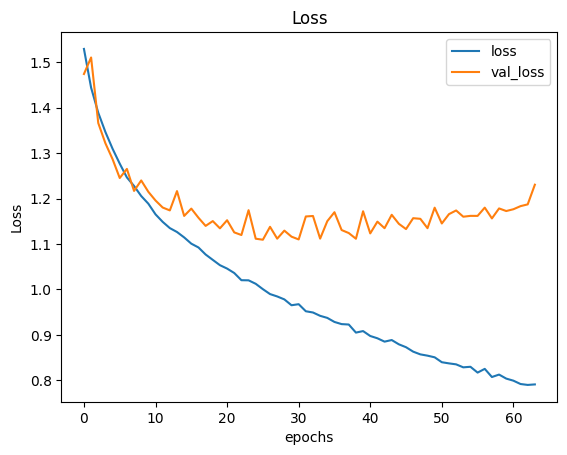

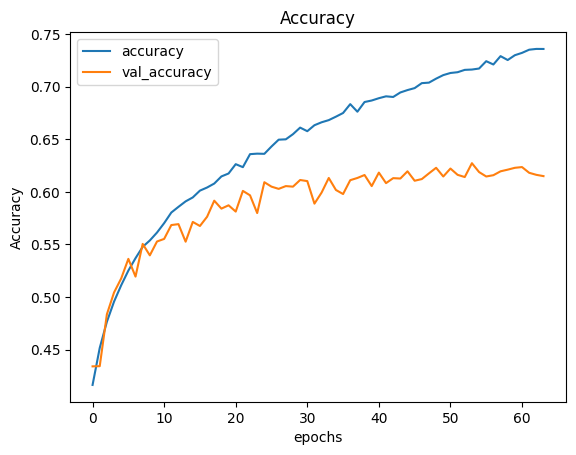

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

#### Matriz de Confusão

113/113 [==============================] - 4s 34ms/step


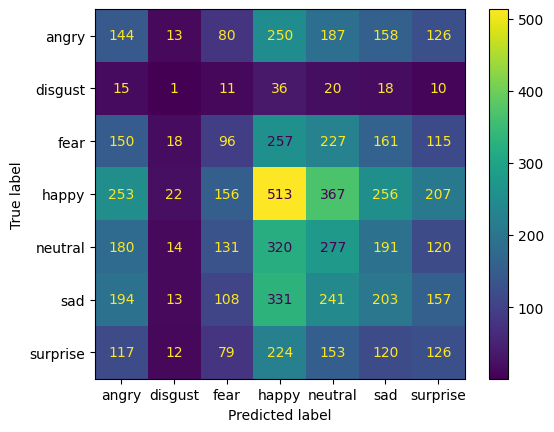

In [ ]:
y_pred = model.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis = 1)

ConfusionMatrixDisplay(confusion_matrix(test_set.classes,y_pred_classes), display_labels=list(training_set.class_indices.keys())).plot()

###Paradigma Baseado em Instância

In [ ]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train ,y_train)
y_pred_KNN = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred_KNN)
print(acc)

0.599609919197548


####Matriz de Confusão

              precision    recall  f1-score   support

       angry       0.50      0.58      0.53       958
     disgust       0.56      0.46      0.50       111
        fear       0.43      0.45      0.44      1024
       happy       0.76      0.82      0.79      1774
     neutral       0.60      0.57      0.58      1233
         sad       0.54      0.41      0.47      1247
    surprise       0.68      0.69      0.68       831

    accuracy                           0.60      7178
   macro avg       0.58      0.57      0.57      7178
weighted avg       0.60      0.60      0.60      7178



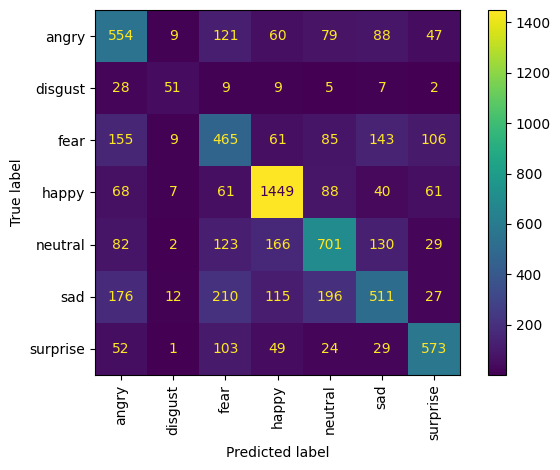

In [ ]:
target_names=emotion_dict
print(classification_report(y_test, y_pred_KNN, target_names=emotion_dict))
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, display_labels=target_names, xticks_rotation="vertical"
)
plt.tight_layout()
plt.show()

## Vizualizando os Erros do Modelo SVM


In [ ]:
def get_label(i):
    return list(training_set.class_indices.keys())[i]
X_test = []

test_path = "/content/test"

for folder in sorted(os.listdir(test_path)):
    image_folder =  test_path +"/"+ folder
    images = sorted(os.listdir(image_folder))
    print ('Loaded the images of -'+'{} having {} images. \n'.format(folder, len(images)))
    for image in images:
        image_path = image_folder +"/"+ image
        x = Image.open(image_path)
        x = x.convert("RGB")
        x = np.array(x)
        img_resize = cv2.resize(x, (224,224))
        X_test.append(img_resize)

Loaded the images of -angry having 958 images. 

Loaded the images of -disgust having 111 images. 

Loaded the images of -fear having 1024 images. 

Loaded the images of -happy having 1774 images. 

Loaded the images of -neutral having 1233 images. 

Loaded the images of -sad having 1247 images. 

Loaded the images of -surprise having 831 images. 



In [ ]:
def plot_errors(true_label,predicted_label):
    rows,cols = 1,5
    fig, ax = plt.subplots(rows,cols,figsize=(10, 3))
    x = ((y_pred_SVM == predicted_label) & (test_set.classes == true_label))
    y = np.where(x == True)[0]
    z = np.random.randint(0,len(y),5)
    fig.suptitle('Predicted : {}, Real : {}' .format(get_label(predicted_label), get_label(true_label)), fontsize=11)
    for col in range(cols):
        ax[col].imshow(X_test[y[z[col]]])
        ax[col].tick_params(
        axis = 'both',
        which='both',
        bottom=False,
        left = False,
        top=False,
        labelbottom=False,
        labelleft=False)


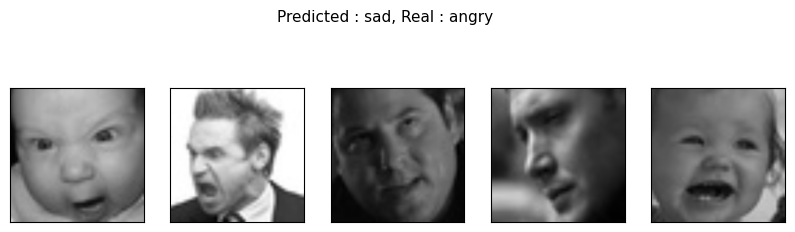

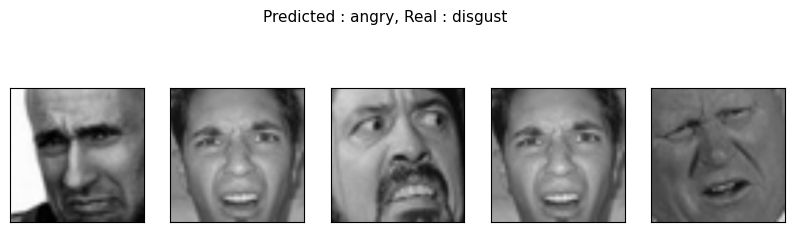

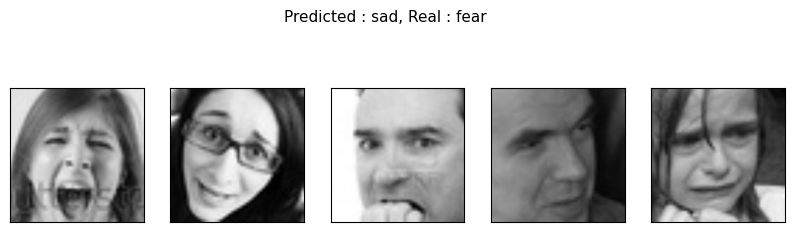

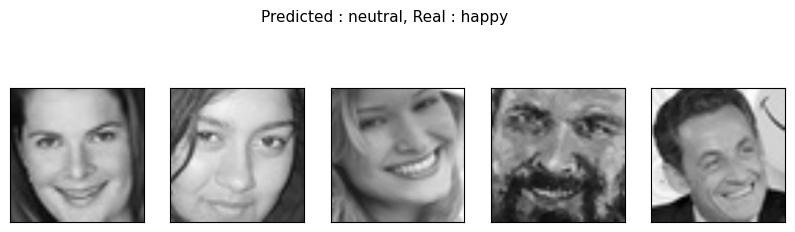

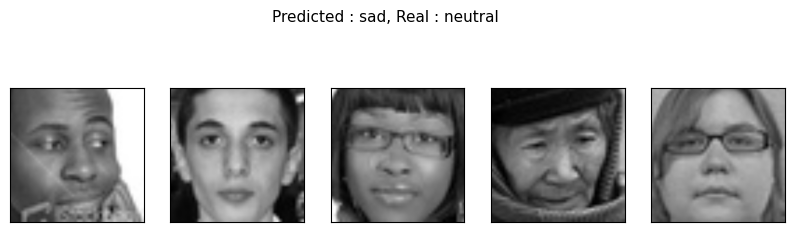

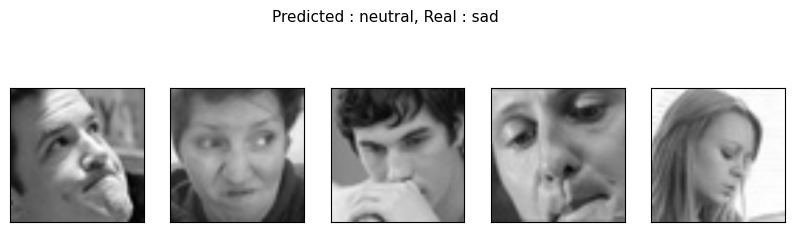

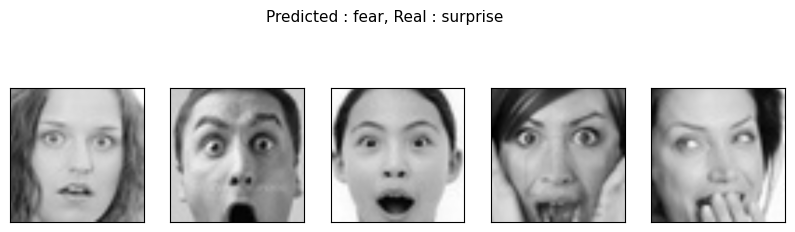

In [ ]:
plot_errors(0,5)
plot_errors(1,0)
plot_errors(2,5)
plot_errors(3,4)
plot_errors(4,5)
plot_errors(5,4)
plot_errors(6,2)